# PacBio 2019 Alzheimer Sequel2 dataset

This notebook demonstrates the data preprocessing, import and basic vizualization of genes with Sashimi plots. 

## Preparation
1) Prepare the working directory and download the reference and data
``` bash
    cd /my/working/directory
    # create some subdirectories
    mkdir -p reference alzheimer/flnc alzheimer/aligned alzheimer/pickle tables plots
    
    # download a reference genome (806 MB)
    genome_link='ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/GRCh38.p13.genome.fa.gz'
    wget -P reference/ -O GRCh38.p13.genome.fa.gz ${genome_link} 
    gunzip reference/GRCh38.p13.genome.fa.gz
    
    # download gencode reference annotation (46.2 MB)
    gff='gencode.v36.chr_patch_hapl_scaff.annotation'
    annotation_link= ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/${gff}.gff3.gz
    wget -P reference/ ${annotation_link} 
    
    # sort by chromosome and position
    (zcat ${gff}.gff3.gz| grep ^"#" ; zcat reference/${gff}.gff3.gz|grep -v ^"#"| sort -k1,1 -k4,4n)|bgzip  > reference/${gff}_sorted.gff3.gz
    # create index
    tabix -p gff reference/${gff}_sorted.gff3.gz
    
    # download the isoseq flnc data (4.1 GB)
    isoseq_link='https://downloads.pacbcloud.com/public/dataset/Alzheimer2019_IsoSeq/FullLengthReads/flnc.bam'
    wget -P alzheimer/flnc -O alzheimer2019_isoseq_flnc.bam ${isoseq_link} 
```

2) Align the isoseq data to the reference genome using minimap2.
If the pacbio isoseq3 workflow is [installed](https://github.com/PacificBiosciences/IsoSeq_SA3nUP/wiki/Tutorial:-Installing-and-Running-Iso-Seq-3-using-Conda) you can use the pacbio version of minimap2 as follows:

``` sh
    #activate the isoseq3 environement (assuming it is called pacbio)
    conda activate pacbio
    n_threads=60
    sample='alzheimer2019_isoseq'
    ref='reference/GRCh38.p13.genome.fa'
    pbmm2 align ${ref} alzheimer/flnc/${sample}_flnc.bam alzheimer/aligned/${sample}_aligned.sorted.bam --preset ISOSEQ --sort -j $n_threads 
```



## Data import

In [1]:
import isotools
print(f'This is isootools version {isotools.__version__}')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


This is isootools version 0.1.3_dev


In [2]:
sample='alzheimer2019_isoseq'
bam=f'alzheimer/aligned/{sample}_aligned.sorted.bam'
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'



In [3]:

try:
    #try to restore previously prepared data (about 2 minutes)
    isoseq=isotools.Transcriptome(f'alzheimer/pickle/{sample}_isotools.pkl')
except FileNotFoundError:
    try:
        #try to restore the reference
        isoseq=isotools.Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        #import the reference from gff3 (3 minutes)
        isoseq=isotools.Transcriptome.from_reference(anno+'.gff3.gz') 
        # save the reference, so it it can be reused for other datasets/analysis
        isoseq.save_reference(anno+'.isotools.pkl') 
    # import the long read data and compare to reference (only one sample for this dataset, takes 30-40 minutes)
    isoseq.add_sample_from_bam(bam, sample_name='alzheimer_1', group='alzheimer') 
    # compute QC metrics for all transcripts
    isoseq.add_biases(genome) #takes 15-20 min
    # update the index for fast gene access by name/id
    isoseq.make_index()
    # save the current data
    isoseq.save(f'alzheimer/pickle/{sample}_isotools.pkl')


3270946it [03:04, 17763.86it/s]
100%|██████████| 4411279.0/4411279 [36:11<00:00, 2031.47reads/s, chr=KI270757.1]
100%|██████████| 287464/287464 [15:26<00:00, 310.13it/s] 


## Quality control and filtering
Isotools allows to flag and filter transcripts based on user defined criteria. This is helpfull e.g. to mark potential artefacts. The default flags are defined by the following constants, stored in dicts.
The key is the flag name (usually all capital letters) and a filter expression, that gets evaluated for each transcript. 
For example, the expression for INTERNAL_PRIMING flag is 'len(exons)==1 and downstream_A_content and downstream_A_content>.5', e.g. it marks mono exon genes with more than 50% A downstream of the transcript. 



In [4]:
from isotools import DEFAULT_GENE_FILTER, DEFAULT_TRANSCRIPT_FILTER,DEFAULT_REF_TRANSCRIPT_FILTER
ref_filter=DEFAULT_REF_TRANSCRIPT_FILTER
#lets define some custom reference filter flags based on the gencode specific transcript information:
ref_filter['HIGH_SUPPORT']='transcript_support_level=="1"'
ref_filter['PROTEIN_CODING']='transcript_type=="protein_coding"'
print(DEFAULT_TRANSCRIPT_FILTER)

gene_filter=DEFAULT_GENE_FILTER
isoseq.add_filter( gene_filter=gene_filter, ref_transcript_filter=ref_filter)


{'INTERNAL_PRIMING': 'len(exons)==1 and downstream_A_content and downstream_A_content>.5', 'RTTS': 'noncanonical_splicing and novel_splice_sites and any(2*i in novel_splice_sites[0] and 2*i+1 in novel_splice_sites[0] for i,_ in noncanonical_splicing)', 'NONCANONICAL_SPLICING': 'noncanonical_splicing', 'NOVEL_TRANSCRIPT': 'annotation is None or annotation[0]>0', 'FRAGMENT': 'fragments', 'NOVEL': 'not annotation or annotation[0]==4', 'UNSPLICED': 'len(exons)==1', 'MULTIEXON': 'len(exons)>1'}


100%|██████████| 287464/287464 [00:26<00:00, 10691.82it/s]


We can depict the summary statistics on the quality control metrics and filter flags.
Isotools distinguishes 3 types of artefacts:

* **Internal priming**, where the primer binds genomic stretches of high adenosine content, yielding apparent novel genes which are typically unspliced. 
* **Reverse transcriptase template switching (RTTS)**, resulting in apperant novel introns, often without canonical splice sites.
* **Truncated fragments**, of transcripts, yielding apperant novel transcription start sites or polyA sites.

In [5]:
#compute some summary statistics on technical artifacts. 
tr_stats=[
    isoseq.transcript_length_hist( add_reference=True, min_coverage=2,tr_filter=dict( remove=['NOVEL_GENE']), ref_filter=dict(include=['HIGH_SUPPORT'])),
    isoseq.downstream_a_hist( tr_filter=dict( remove=['NOVEL_GENE', 'UNSPLICED']), ref_filter=dict(remove=['UNSPLICED'])),
    isoseq.downstream_a_hist( tr_filter=dict(include=['NOVEL_GENE', 'UNSPLICED'])),
    isoseq.direct_repeat_hist(bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))

#statistic on the filter flags
f_stats=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1)
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

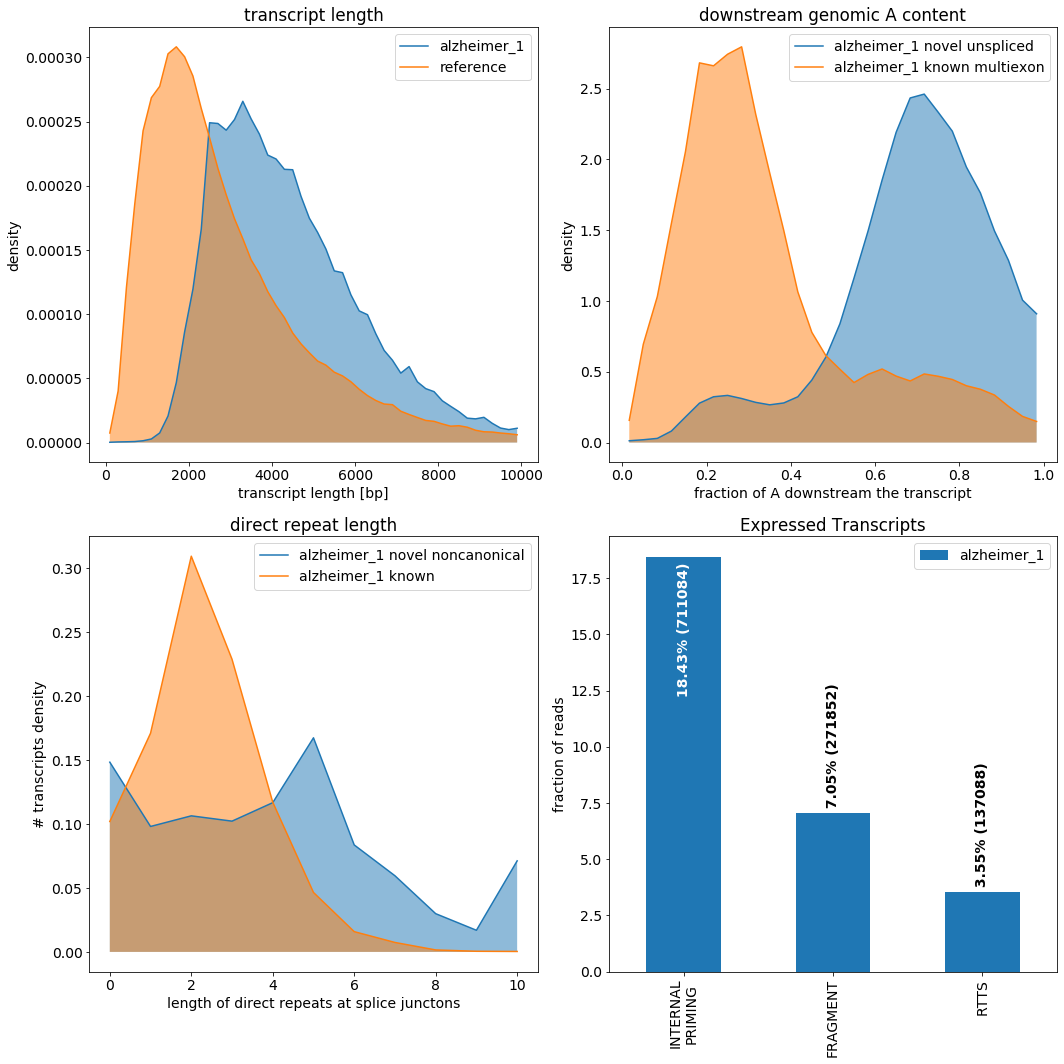

In [6]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 14})


fig, axs = plt.subplots(2,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],**tr_stats[0][1])  
#B) internal priming
plot_distr(tr_stats[4][0],smooth=3,ax=axs[0,1],density=True,fill=True, **tr_stats[4][1])  
#C) RTTS
plot_distr(tr_stats[3][0],ax=axs[1,0],density=True,**tr_stats[3][1])  
#D) frequency of artifacts
plot_bar(f_stats[0],ax=axs[1,1],drop_categories=['MULTIEXON','NOVEL\nTRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL\nSPLICING' ],**f_stats[1])  

fig.tight_layout()


This particular dataset seems to have relativly high fraction of internal priming, affecting 18.4% of the full lenght reads. 

## Novel alternative splicing classification
In order to assess the types of novel transcripts, isotools implements a novel classification scheme. 
This artificial example covers all classes, and can be modified to test specific cases and combination of classes. 
The labels in the plots get reflect by the assigned classes.

FSM: {'FSM': [0]}
5' fragment: {"5' fragment": [[12, 33]]}
3' fragment: {"3' fragment": [[55, 80]]}
mono exon: {'mono-exon': []}
exon skipping: {'exon skipping': [[30, 40]]}
intron retention: {'intron retention': [(20, 30)]}
novel combination: {'novel combination': []}
novel junction: {'exon skipping': [[50, 60]]}
novel exonic TSS: {'novel exonic TSS': [(26, 30)]}
novel exonic PAS: {'novel exonic PAS': [(60, 66)]}
novel 5' splice site: {"novel 5' splice site": [(24, -4)]}
novel 3' splice site: {"novel 3' splice site": [(26, 4)]}
novel exon: {'novel exon': [[43, 47]]}
novel intronic TSS: {'novel intronic TSS': [[43, 47]]}
novel intronic PAS: {'novel intronic PAS': [[82, 90]]}


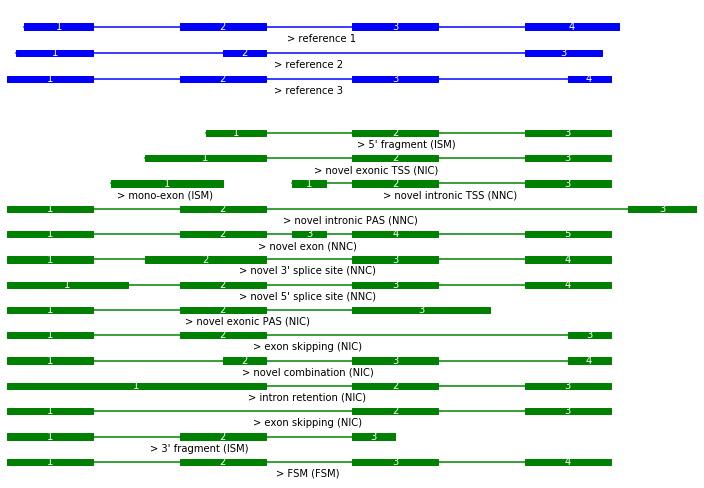

In [7]:
ref=[[[12,20],[30,40], [50,60],[70,81]],
     [[11,20],[35,40],         [70,79]],
     [[10,20],[30,40], [50,60],[75,80]]]
novel={'FSM':         [[10,20],[30,40], [50,60],[70,80]],
       "5' fragment": [[33,40], [50,60],[70,80]],
       "3' fragment": [[10,20],[30,40], [50,55]],
       "mono exon"  : [[22,35]],
       "exon skipping"     :  [[10,20], [50,60],[70,80]],
       "intron retention"  :  [[10,40], [50,60],[70,80]],
       "novel combination" :  [[10,20],[35,40], [50,60],[75,80]],
       "novel junction"  :   [[10,20],[30,40], [75,80]],
       "novel exonic TSS"  :  [[26,40], [50,60],[70,80]],
       "novel exonic PAS"  :  [[10,20],[30,40], [50,66]],
       "novel 5' splice site":[[10,24],[30,40], [50,60],[70,80]],
       "novel 3' splice site":[[10,20],[26,40], [50,60],[70,80]],
       "novel exon"  :        [[10,20],[30,40],[43,47], [50,60],[70,80]],
       "novel intronic TSS" : [[43,47],[50,60],[70,80]],
       "novel intronic PAS" : [[10,20],[30,40], [82,90]]}
ref={'transcripts':[{'exons':e, 'transcript_name':f'reference {i+1}'} for i,e in enumerate(ref)]}
transcripts=[{'exons':e, 'transcript_name':n} for n,e in novel.items()]
example=isotools.Gene(10,80,{'strand':'+','ID':'example','reference':ref, 'transcripts':transcripts},None)
f,axs=plt.subplots(2,figsize=(10,7), gridspec_kw={'height_ratios': [1, 4]})
cat=['FSM','ISM','NIC','NNC','novel gene']
sg=example.ref_segment_graph
for novel in example.transcripts:
    alt_splice=sg.get_alternative_splicing(novel['exons'])
    print(f"{novel['transcript_name']}: {alt_splice[1]}")
    novel['transcript_name']=f"{','.join(alt_splice[1])} ({cat[alt_splice[0]]}) "
    
example.gene_track(ax=axs[0], x_range=[10,90], title='')
example.gene_track(reference=False,ax=axs[1], x_range=[10,90], title='', color='green')  
for ax in axs:
    ax.get_xaxis().set_visible(False)
f.tight_layout()


During import, all isoseq transcripts get classified using this scheme. 
We can depict the number of identified novel classes. 
Note that we use the flags defined above to filter transcripts affected by one of the 3 artefacts. 

In [8]:

cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cat[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

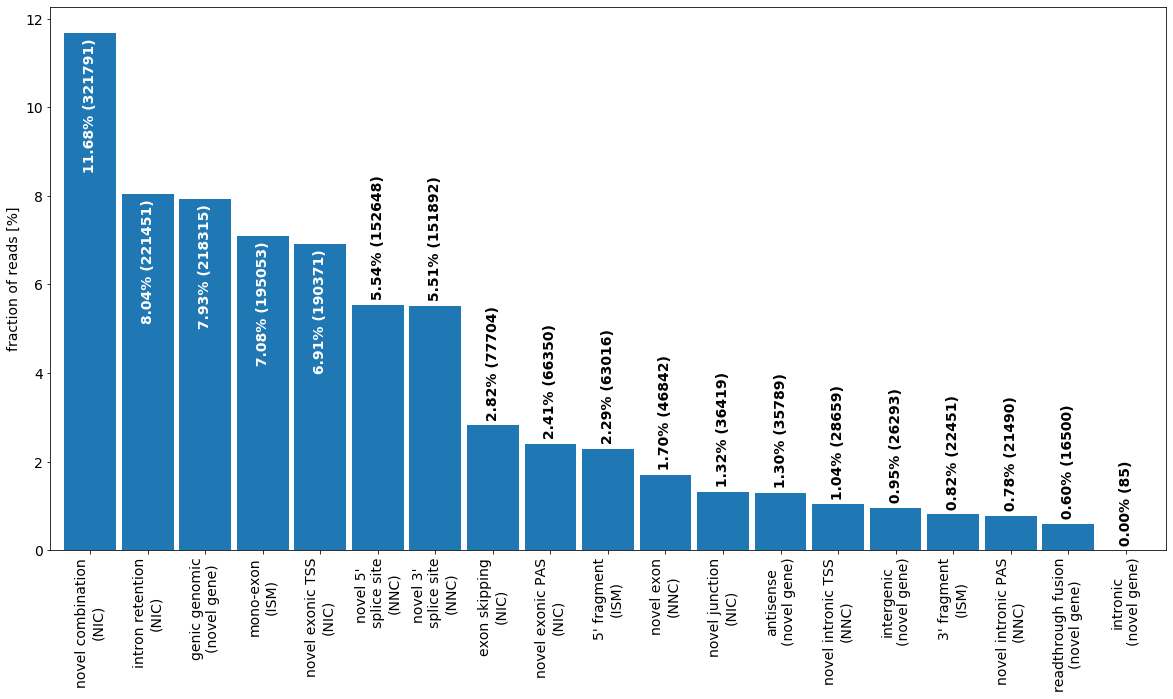

In [9]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (20,10)
_=plot_bar(altsplice[0][0],bar_width=.9,ylabel='fraction of reads [%]', legend=False, rot=90,drop_categories=['FSM'])  


## Data exploration

In [10]:
#access gene of interest by Name
g=isoseq['MAPT']
print(g)
#this reveals that the MAPT has 267 different variants, according to isoseq. 
total_cov=g.coverage.sum()
#However, most are supported by few reads only
print(f'{sum([cov>total_cov *.01 for cov in g.coverage][0])} transcripts contribute at least 1% to that gene')
#lets look at the primary transcript
max_i=np.argmax(g.coverage)
print(f'The primary transcript is number {max_i} and contributes {g.coverage[0,max_i]/total_cov:.2%}  ({g.coverage[0,max_i]}/{total_cov})')
#all the information for this transcript are stored in this dict:
primary=g.transcripts[max_i]
print(f'\nThese are the infos for this transcript: {primary}')
# this reveals that it is a full splice match with reference transcript 7
print(f'\nThe corresponding reference transcript: {g.ref_transcripts[7]}')

Gene MAPT chr17:45894550-46028334(+), 16 reference transcripts, 267 expressed transcripts
12 transcripts contribute at least 1% to that gene
The primary transcript is number 8 and contributes 16.56%  (450/2718)

These are the infos for this transcript: {'exons': [[45894371, 45894686], [45962320, 45962470], [45978374, 45978440], [45987039, 45987095], [45991459, 45991586], [45996398, 45996664], [46010309, 46010402], [46014242, 46014324], [46018617, 46018730], [46023955, 46028331]], 'strand': '+', 'coverage': {'alzheimer_1': 450}, 'annotation': (0, {'FSM': [7]}), 'novel_splice_sites': (array([], dtype=int64),), 'direct_repeat_len': [5, 2, 2, 3, 3, 6, 3, 3, 2], 'downstream_A_content': 0.3333333333333333, 'filter': ['MULTIEXON']}

The corresponding reference transcript: {'transcript_id': 'ENST00000446361.7', 'transcript_type': 'protein_coding', 'transcript_name': 'MAPT-208', 'transcript_support_level': '1', 'exons': [(45894673, 45894686), (45962320, 45962470), (45978374, 45978440), (4598703

In [11]:
#we can iterate over transcripts and filter by flag:
i=0
for g,trnr,tr in isoseq.iter_transcripts(include=['INTERNAL_PRIMING']):
    print(f'transcript nr {trnr} of {g} with a coverage of {g.coverage[0,trnr]}') 
    i+=1
    if i>10:
        break
    

transcript nr 0 of Gene PB_novel_219070 GL000194.1:67798-71155(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 2
transcript nr 0 of Gene PB_novel_219069 GL000194.1:64072-69086(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 4
transcript nr 0 of Gene PB_novel_219068 GL000194.1:61491-66398(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 7
transcript nr 0 of Gene PB_novel_219088 GL000195.1:66348-68729(+), 0 reference transcripts, 1 expressed transcripts with a coverage of 8
transcript nr 0 of Gene PB_novel_219090 GL000195.1:74999-77143(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_219082 GL000195.1:51826-53921(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_219094 GL000195.1:155779-159045(+), 0 reference transcripts, 1 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_219084

In [12]:
#we can also iterate over transcripts and filter by region (chr[:start-end]), novelty category, or request a minimum coverage:
for g,trnr,tr in isoseq.iter_transcripts(region='chr1', include=['novel exon'], min_coverage=100):
    print(f'Gene {g.name} has a highly covered transcript with novel exon:')
    print(f'Transcript nr {trnr}  with a coverage of {g.coverage[0,trnr]}/{g.coverage.sum()}') 
    print(f'The novel exon is at position {tr["annotation"][1]["novel exon"]}') 

    

Gene KIFAP3 has a highly covered transcript with novel exon:
Transcript nr 2  with a coverage of 252/678
The novel exon is at position [[169925786, 169925855]]
Gene AC244669.1 has a highly covered transcript with novel exon:
Transcript nr 2  with a coverage of 169/429
The novel exon is at position [[120258775, 120258883]]


## Data vizualization
We depict the MAPT gene with its two major exon skipping events as sashimi plot.

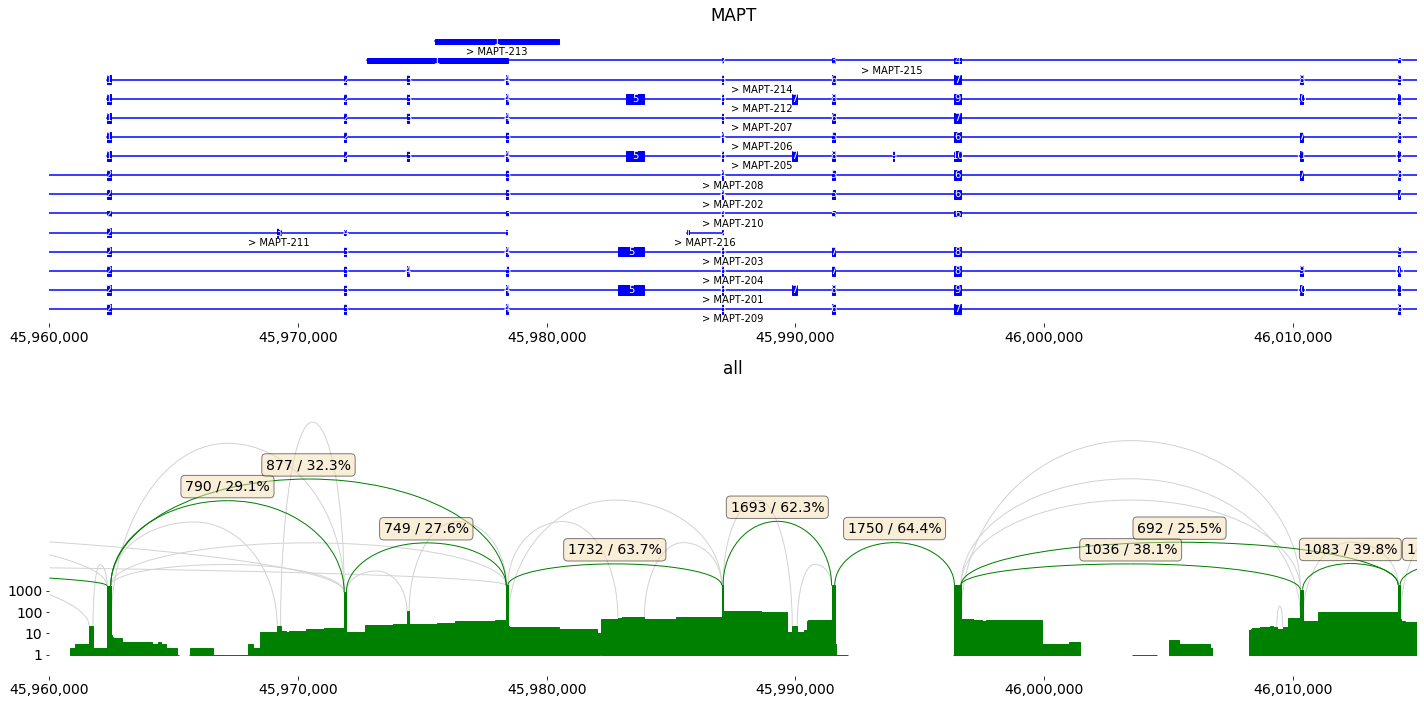

In [13]:
plt.rcParams["figure.figsize"] = (20,10)
fig,axs=isoseq['MAPT'].sashimi_figure(x_range=[45960000,46015000])
fig.tight_layout()